# LA Type A Cell Example

### Install dependencies for ACT and setup environment

In [1]:
!pip install act-neuron

import os
import sys

from act import simulator, analysis
from IPython.display import Image
import numpy as np

# Download the repository with all relevant model files if in google colab
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !rm -rf ./ACT
    !git clone https://github.com/V-Marco/ACT
    base_dir = "./ACT"
else:
    base_dir = "../.."

### The non-segregated approach

Define a config file for ACT to run a simulation.

In [5]:
config = {
    "cell": {
        "hoc_file": os.path.join(base_dir, "data/LA/A/template.hoc"),
        "modfiles_folder": os.path.join(base_dir, "data/LA/A/orig_modfiles"),
        "name": "Cell_A",
    },
    "simulation_parameters": {
        "h_v_init": -70.0,  # (mV)
        "h_tstop": 2000,  # (ms)
        "h_i_delay": 500,  # (ms)
        "h_i_dur": 1500,  # (ms)
        "h_dt": 0.025,
    },
    "optimization_parameters": {
        "amps": list(np.arange(-2, 10, 0.1)),
        "params": [
            {"channel": "glbar_leak", "low": 2.75e-5, "high": 1e-4}, # leak, passive
            {"channel": "ghdbar_hd", "low": 1.15e-05, "high": 4.6e-05}, # hd, passive
            {"channel": "gbar_nap", "low": 0.000071, "high": 0.000284}, # nap, lto and hto
            {"channel": "gmbar_im", "low": 0.001, "high": 0.004}, # im, lto and hto
            {"channel": "gbar_na3", "low": 0.015, "high": 0.06}, # na3, spiking/adaptation
            {"channel": "gkdrbar_kdr", "low": 0.00075, "high": 0.003}, # kdr, spiking/adaptation
            {"channel": "gcabar_cadyn", "low": 3e-5, "high": 1.2e-4}, # cadyn, spiking/adaptation
            {"channel": "gsAHPbar_sAHP", "low": 0.0045, "high": 0.018}, # sahp, spiking/adaptation
        ],
        "target_V": None,  # Target voltages
        "target_params": [5.5e-5, 2.3e-05, 0.000142, 0.002, 0.03, 0.0015, 6e-5, 0.009],
        "num_repeats": 3,
        "num_amps_to_match": 12,
        "num_epochs": 5000,
    },
    "summary_features": {
        "spike_threshold": 20,  # (mV)
        # Target-sim match conditions (max abs diff between sim and target)
        "mc_num_spikes": 1,
        "mc_interspike_time": 200,  # (ms)
        "mc_min_v": 1,  # (mV)
        "mc_mean_v": 2,  # (mV)
        "mc_max_v": 1,  # (mV)
    },
    "segregation": [
        { # passive
            "params": ["glbar_leak", "ghdbar_hd"],
            "voltage": [-80, -67.5],
        },
        { # lto
            "params": ["gbar_nap", "gmbar_im"],
            "voltage": [-67.5, -57.5],
        },
        { # spking / adaptation
            "params": ["gbar_na3", "gkdrbar_kdr", "gcabar_cadyn", "gsAHPbar_sAHP"],
            "voltage": [-57.5, 0],
        },
        { # hto
            "params": ["gbar_nap", "gmbar_im"],
            "voltage": [-40, -30],
        },
    ],
    "output": {"folder": "output_LA_A", "produce_plots": True},
    "run_mode": "original",  # "original", "segregated"
}

In [ ]:
# Run the simulation

simulator.run(config)

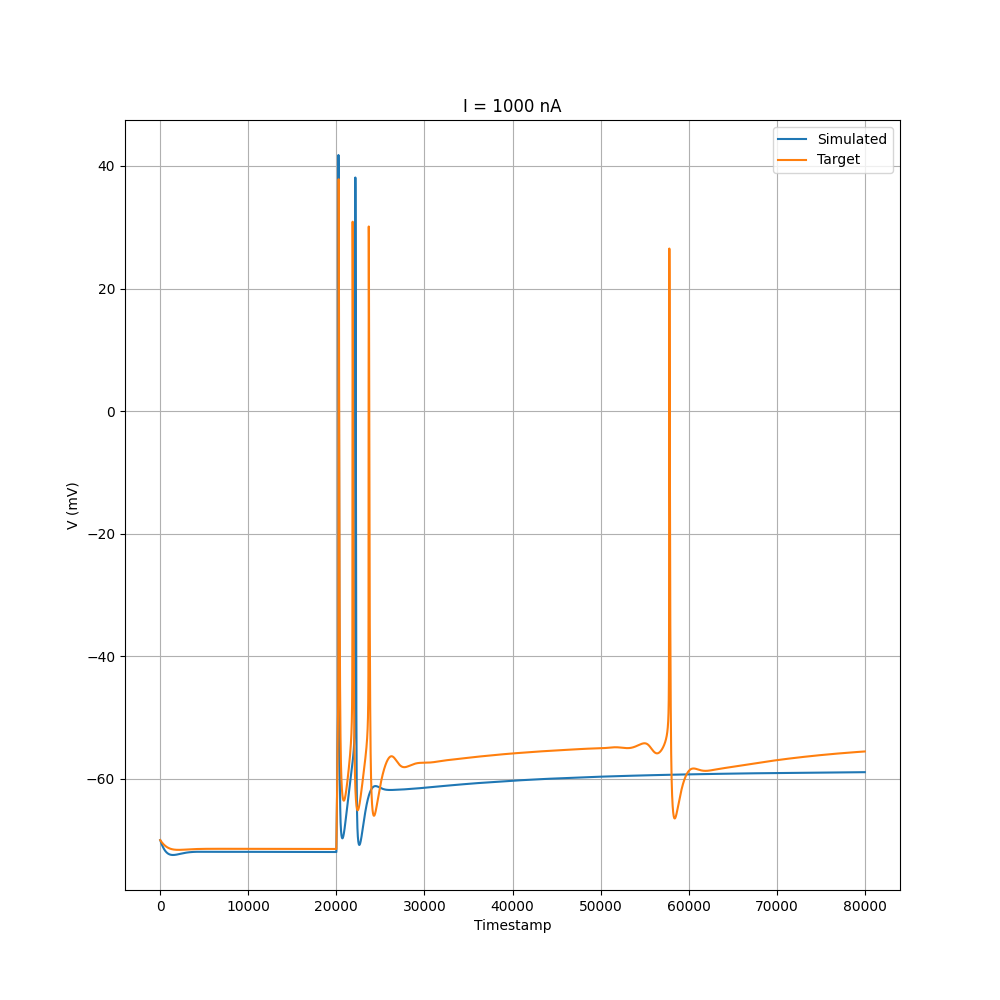

In [ ]:
Image(filename="./output_LA_A/original/1000nA.png")

In [ ]:
analysis.print_run_stats(config)

output_LA_A : original
Med MSE: 51.6922 (71.3803)
Med Corr: 0.8752 (0.1093)

Predicted values:
   glbar_leak  ghdbar_hd  gbar_nap  gmbar_im  gbar_na3  gkdrbar_kdr  \
0     0.00004   0.000044  0.000243     0.004      0.06        0.003   

   gcabar_cadyn  gsAHPbar_sAHP  
0       0.00012       0.008336  
Target values:
   glbar_leak  ghdbar_hd  gbar_nap  gmbar_im  gbar_na3  gkdrbar_kdr  \
0    0.000055   0.000023  0.000142     0.002      0.03       0.0015   

   gcabar_cadyn  gsAHPbar_sAHP  
0       0.00006          0.009  
Error:
   glbar_leak  ghdbar_hd  gbar_nap  gmbar_im  gbar_na3  gkdrbar_kdr  \
0   -0.000015   0.000021  0.000101     0.002      0.03       0.0015   

   gcabar_cadyn  gsAHPbar_sAHP  
0       0.00006      -0.000664  

Pred MAE: 0.0043

Passive properties:
{
  "leak_conductance_variable": null,
  "leak_reversal_variable": null,
  "r_in": 71.47682189941406,
  "tau": 14.0,
  "v_rest": -71.93914031982422
}
----------



### Segregation with analytical setting of passive properties

In this section, let's set the passive properties for the cell so they can be analytically determined instead of using a model network.

To determine the appropriate parameters for the H passive channel:

```
alpha = exp(0.0378*2.2*(v--75))
beta = exp(0.0378*2.2*0.4*(v--75))
```
Fit Inf function from `neuroneq`:
```
1.0/(1.0+(exp((v+75.0)/(-20.04))))
# at vrest of -70
1.0/(1.0+(exp((-70+75.0)/(-20.04))))
0.56205
```
Then adjust `e_leak` (which is passive property v_rest) according to
```
[ mH(Vrest)* gmaxH* (Vrest - E_H) + gleak*Vrest ] / gleak

[ 0.56205 * 2.3e-05 * (-70 - -75) + gleak*-70] / gleak
# Where gleak is
1 / (r_in * area) * 1e2
1 / 141 * area * 1e2
0.00007824

( 0.56205 * 2.3e-05 * (-70 - -75) + 0.00007824*-70) / 0.00007824
−69.173878451
```


In [15]:
config = {
    "cell": {
        "hoc_file": os.path.join(base_dir, "data/LA/A/template.hoc"),
        "modfiles_folder": os.path.join(base_dir, "data/LA/A/seg_modfiles"),
        "name": "Cell_A",
        "passive_properties": {
            "v_rest": -69.17387,
            "r_in": 141,
            "tau": 30.88,
            "leak_conductance_variable": "glbar_leak",  # eg: g_leak
            "leak_reversal_variable": "el_leak",  # eg: e_leak
        },
    },
    "simulation_parameters": {
        "h_v_init": -70.0,  # (mV)
        "h_tstop": 2000,  # (ms)
        "h_i_delay": 500,  # (ms)
        "h_i_dur": 1500,  # (ms)
        "h_dt": 0.025,
    },
    "optimization_parameters": {
        "amps": list(np.arange(-2, 3, 0.025)),
        "params": [
            #{"channel": "ghdbar_hd", "low": 1.15e-05, "high": 4.6e-05}, # hd, passive
            {"channel": "gbar_nap", "low": 0.000071, "high": 0.000284}, # nap, lto and hto
            {"channel": "gbar_im", "low": 0.001, "high": 0.004}, # im, lto and hto
            {"channel": "gbar_na3", "low": 0.015, "high": 0.06}, # na3, spiking/adaptation
            {"channel": "gbar_kdr", "low": 0.00075, "high": 0.003}, # kdr, spiking/adaptation
            {"channel": "gcabar_cadyn", "low": 3e-5, "high": 1.2e-4}, # cadyn, spiking/adaptation
            {"channel": "gsAHPbar_sAHP", "low": 0.0045, "high": 0.018}, # sahp, spiking/adaptation
        ],
        "target_V": None,  # Target voltages
        "target_params": [0.000142, 0.002, 0.03, 0.0015, 6e-5, 0.009], #[2.3e-05, 0.000142, 0.002, 0.03, 0.0015, 6e-5, 0.009],
        "num_repeats": 3,
        "num_amps_to_match": 12,
        "num_epochs": 5000,
    },
    "summary_features": {
        "spike_threshold": 20,  # (mV)
        # Target-sim match conditions (max abs diff between sim and target)
        "mc_num_spikes": 1,
        "mc_interspike_time": 200,  # (ms)
        "mc_min_v": 1,  # (mV)
        "mc_mean_v": 2,  # (mV)
        "mc_max_v": 1,  # (mV)
    },
    "segregation": [
        #{ # passive
        #    "params": ["ghdbar_hd"],
        #    "voltage": [-80, -67.5],
        #},
        { # lto
            "params": ["gbar_nap", "gbar_im"],
            "voltage": [-67.5, -57.5],
        },
        { # spking / adaptation
            "params": ["gbar_na3", "gbar_kdr", "gcabar_cadyn", "gsAHPbar_sAHP"],
            "voltage": [-57.5, 0],
        },
        { # hto
            "params": ["gbar_nap", "gbar_im"],
            "voltage": [-40, -30],
        },
    ],
    "output": {"folder": "output_LA_A", "produce_plots": True},
    "run_mode": "segregated",  # "original", "segregated"
}

In [16]:
simulator.run(config)

/home/tyler/neuro-venv/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


INFO : Using neuron-nightly Package (Developer Version)
/home/tyler/git_stage/ACT/examples/LA
Mod files: "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/cadyn.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/capool.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/currentclamp.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/h.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/im.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/kaprox.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/kdrca1DA.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/kdrca1.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/leakDA.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/leak.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/na3DA.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_modfiles/na3.mod" "../../data/LA/A/seg_modfiles/../../data/LA/A/seg_m

Translating cadyn.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/cadyn.c
Translating capool.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/capool.c
Thread Safe
Translating currentclamp.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/currentclamp.c
Thread Safe
Thread Safe
Translating h.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/h.c
Translating kaprox.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/kaprox.c
Translating im.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/im.c
Thread Safe
Thread Safe
Thread Safe
Translating kdrca1DA.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/kdrca1DA.c
Thread Safe
Translating kdrca1.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/kdrca1.c
Translating leakDA.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/leakDA.c
Thread Safe
Thread Safe
Translating leak.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/leak.c
Thread Safe
Translating na3DA.mod into /home/tyler/git_stage/ACT/examples/LA/x86

 -> Compiling h.c
 -> Compiling im.c
 -> Compiling kaprox.c
 -> Compiling kdrca1DA.c
 -> Compiling kdrca1.c
 -> Compiling leakDA.c
 -> Compiling leak.c
 -> Compiling na3DA.c
 -> Compiling na3.c
 -> Compiling nap.c
 -> Compiling nat.c
 -> Compiling sahp.c
 -> Compiling sahpNE.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread

(2023-09-11 15:46:50.619639)-[START]
(2023-09-11 15:46:50.624755)-[INFO]: Number of amplitudes: 200
Successfully created x86_64/special
(2023-09-11 15:48:55.528698)-[INFO]: Target voltage shape: torch.Size([200, 80000])
Setting el_leak = -66.408
Setting Cell_A[0].soma[0].glbar_leak = 0.00007824
Setting Cell_A[0].soma[0].cm = 2.41605906
(2023-09-11 15:48:55.656428)-[INFO]: Matching 12 amplitudes.
(2023-09-11 15:50:46.680079)-[INFO]: Total amplitudes matched: 1/12.
(2023-09-11 15:52:36.979861)-[INFO]: Total amplitudes matched: 5/12.
(2023-09-11 15:54:25.294970)-[INFO]: Total amplitudes matched: 6/12.
(2023-09-11 15

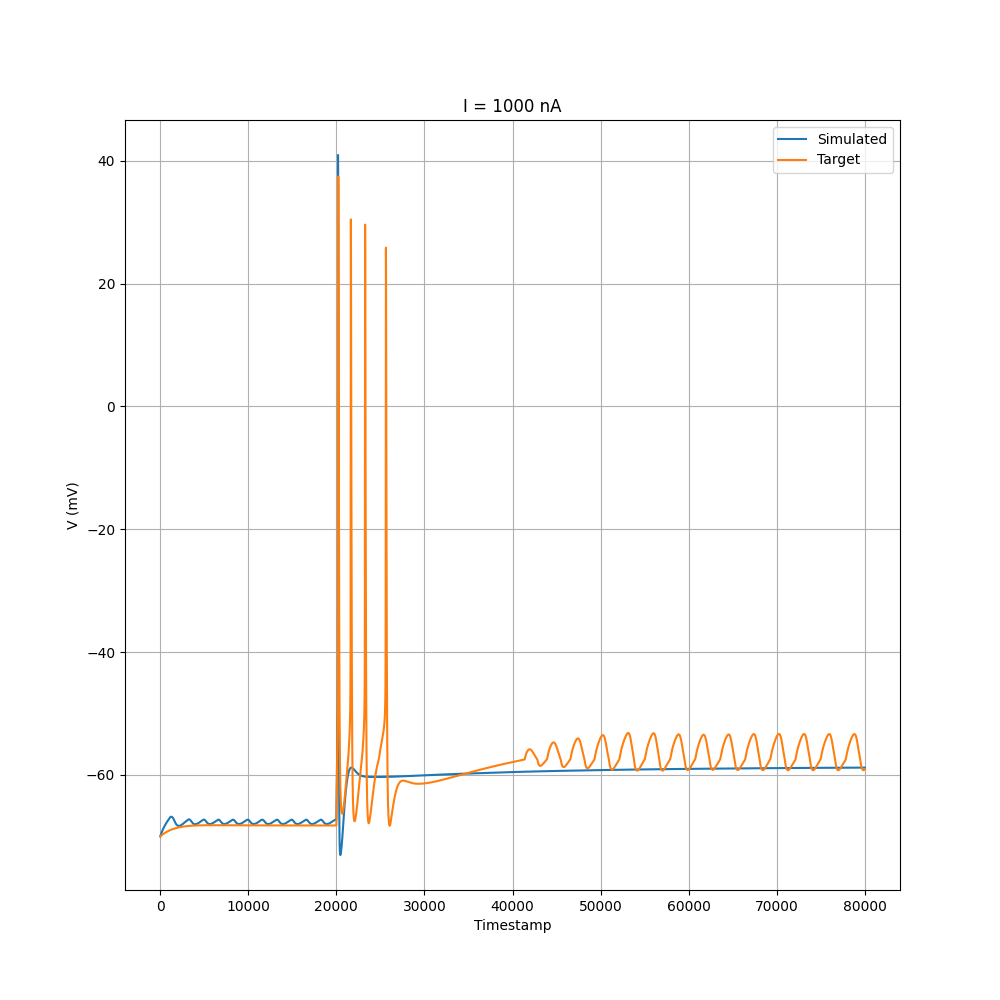

In [17]:
Image(filename="./output_LA_A/segregated/1000nA.png")

In [19]:
analysis.print_run_stats(config)

output_LA_A : segregated
Med MSE: 36.3738 (779.3463)
Med Corr: 0.7207 (0.1831)

Predicted values:
   gbar_nap   gbar_im  gbar_na3  gbar_kdr  gcabar_cadyn  gsAHPbar_sAHP
0  0.000076  0.003969  0.057396  0.002995       0.00012       0.017991
Target values:
   gbar_nap  gbar_im  gbar_na3  gbar_kdr  gcabar_cadyn  gsAHPbar_sAHP
0  0.000142    0.002      0.03    0.0015       0.00006          0.009
Error:
   gbar_nap   gbar_im  gbar_na3  gbar_kdr  gcabar_cadyn  gsAHPbar_sAHP
0 -0.000066  0.001969  0.027396  0.001495       0.00006       0.008991

Pred MAE: 0.0067

Passive properties:
{
  "leak_conductance_variable": "glbar_leak",
  "leak_reversal_variable": "el_leak",
  "r_in": 94.81834411621094,
  "tau": 17.575,
  "v_rest": -67.32881164550781
}
----------



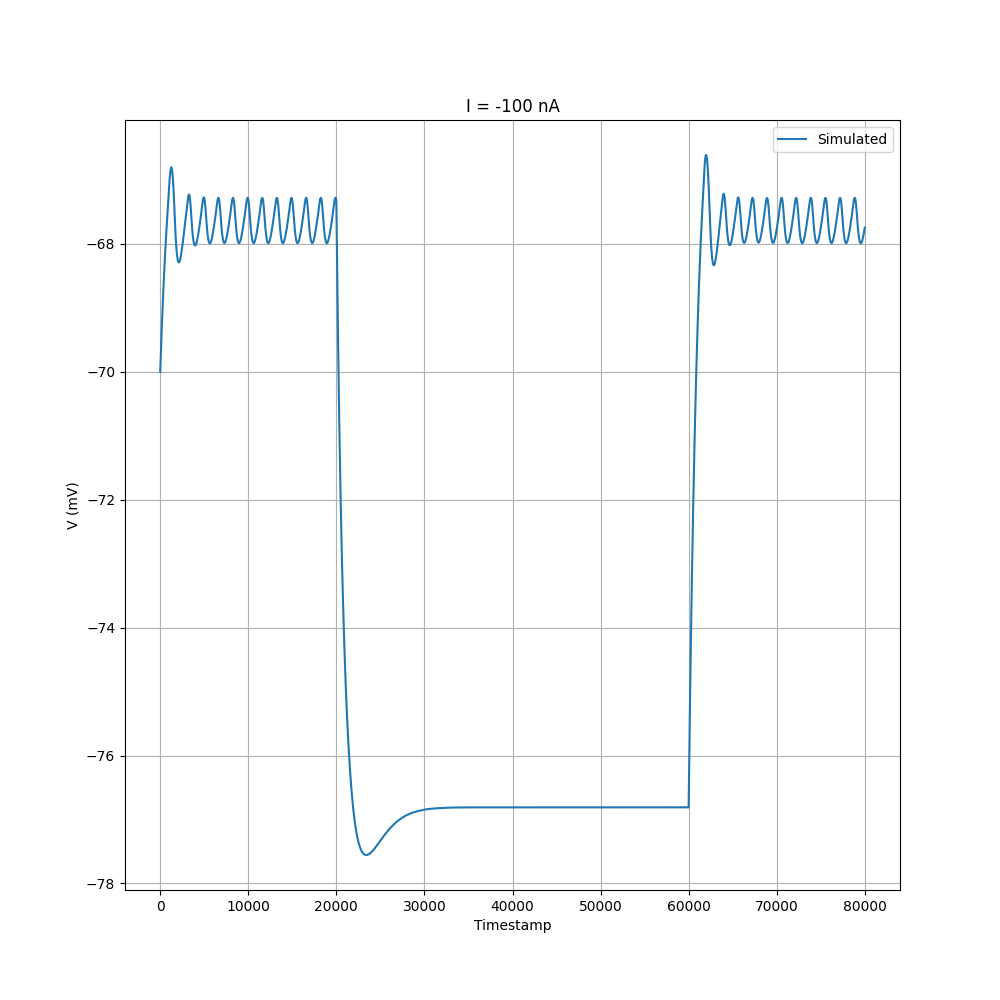

In [20]:
Image(filename="./output_LA_A/segregated/passive_-100nA.png")